# Setup

In [ ]:
running_on_colab = True
import torch
if running_on_colab:
    print(torch.__version__)
    !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q git+https://github.com/snap-stanford/deepsnap.git

    from google.colab import drive
    drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/GCNN/graph_data/graphsage_prototype/'
    data_folder = filepath+"data/"
    models_folder = filepath+"models/"
    experiments_folder = filepath+"experiments/"

    """cosas para configurar en colab, como mount drive y poner bien los folders de guardado, instalar librerias etc"""
else:
    data_folder = "../../../data/processed/graph_data_nohubs/"
    models_folder = "../../../data/models/"
    experiments_folder = "../../../data/experiments/"

1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


In [ ]:
import datetime
import pickle

import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_sparse import matmul
import deepsnap.hetero_gnn
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

# Utility functions

Estas normalmente irían en otro script .py pero como estamos en un notebook las pongo en esta sección

In [ ]:
def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

def load_edge_csv(path, src_index_col, dst_index_col, mappings, edge_type_col,src_type_col,dst_type_col, **kwargs):
    """Returns edge dataframe and a dict of edge indexes. Nodes are indexed according to the "heterodata index", using the node mappings from load_node_csv. 
    Edge indexes are tensors of shape [2, num_edges]. Dict is indexed by triplets of shape (src_type, edge_type, dst_type)."""
    df = pd.read_csv(path, **kwargs)
    df["edge_triple"] = list(zip(df[src_type_col],df[edge_type_col], df[dst_type_col]))
    edge_triplets = df["edge_triple"].unique()

    edge_index_dict = dict()
    for edge_triplet in edge_triplets:

        sub_df = df[df.edge_triple == edge_triplet]
        src_type,edge_type,dst_type = edge_triplet

        src_mapping = mappings[src_type]
        dst_mapping = mappings[dst_type]

        src = [src_mapping[index] for index in sub_df[src_index_col]]
        dst = [dst_mapping[index] for index in sub_df[dst_index_col]]
        edge_index = torch.tensor([src, dst])
        edge_index_dict[edge_triplet] = edge_index

    return df, edge_index_dict

def create_heterodata(node_map, edge_index):
    """Initializes HeteroData object from torch_geometric and creates corresponding nodes and edges, without any features"""
    data = HeteroData()
    for node_type,vals in node_map.items():
        # Initialize all node types without features
        data[node_type].num_nodes = len(vals)
    
    for edge_triplet, index in edge_index.items():
        src_type, edge_type, dst_type = edge_triplet
        data[src_type, edge_type, dst_type].edge_index = index
    
    return data

def get_reverse_types(edge_types):
    newlist = []
    for edge in edge_types:
        rev = tuple(reversed(edge))
        if rev != edge:
            if edge not in newlist:
                newlist.append(rev)
        else:
            newlist.append(rev)

    reversed_newlist = [tuple(reversed(edge)) for edge in newlist]

    return newlist, reversed_newlist

def initialize_features(data_object,feature,dim):
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

# Model 

Implementación del modelo. Como es un prototipo y lo hice para aprender, agregué prints que van describiendo que operaciones está haciendo. Para entrenar, apagar los prints con quiet=True

In [ ]:
quiet = True

def talk(msg, quiet=quiet):
    if not quiet:
        print(msg)

def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}

    msg_types = hetero_graph.edge_types
    for key in msg_types:
        if first_layer:
            dst_feature_dim = hetero_graph.num_node_features[key[2]]
            src_feature_dim = hetero_graph.num_node_features[key[0]]
            convs[key] = conv(src_feature_dim, dst_feature_dim, hidden_size)
        else:
            convs[key] = conv(hidden_size, hidden_size, hidden_size)

    return convs

def hetero_apply_function(x: dict,func) -> dict:
    """X es el diccionario de node embeddings o features, {node_type: tensor}.
    Aplica func a cada entrada del diccionario, devuelve un dict de la misma forma."""
    x_transformed = {}
    for key,val in x.items():
        transformed_val = func(val)
        x_transformed[key] = transformed_val
    
    return x_transformed

class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super().__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_update = nn.Linear(2*out_channels, out_channels)

    def forward(self,node_feature_src, node_feature_dst,edge_index):
        talk("HeteroGNN forward")
        talk(f"Node feature src shape: {node_feature_src.shape}, Node feature dst shape: {node_feature_dst.shape}, edge index shape: {edge_index.sparse_sizes()}")
        out = self.propagate(edge_index, node_feature_src=node_feature_src,node_feature_dst=node_feature_dst)
        return out

    def message_and_aggregate(self, edge_index, node_feature_src):
        talk("HeteroGNN msg and agg")
        talk(f"node_feature src shape: {node_feature_src.shape}")
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)
        return out

    def update(self, aggr_out, node_feature_dst):
        talk("HeteroGNN update")
        talk(f"Aggr_out shape: {aggr_out.shape}")
        talk(f"Dst feature shape: {node_feature_dst.shape}")
        dst_msg = self.lin_dst(node_feature_dst)
        src_msg = self.lin_src(aggr_out)

        talk(f"Concat: dst_msg shape: {dst_msg.shape}, src_msg shape: {src_msg.shape}")
        full_msg = torch.concat((dst_msg, src_msg), dim=1)

        talk(f"Full msg shape: {full_msg.shape}")
        out = self.lin_update(full_msg)

        talk(f"After update shape: {out.shape}")
        return out


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, aggr="mean"):
        super().__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, node_features, edge_indices):
        talk("\n ------ Wrapper forward ------ ")
        message_type_emb = {}

        for message_key, adj in edge_indices.items():
            talk(f"\n{message_key}\n")
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]

            message_type_emb[message_key] = self.convs[message_key](node_feature_src,node_feature_dst,adj)

        # {dst: [] for src, type, dst in message_type.emb.keys()}
        # {tipo de nodo: [lista de embeddings obtenidos]}
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}

        for (src, edge_type, dst), item in message_type_emb.items():
            #esto es para saber que indice es cada terna/msg type
            mapping[len(node_emb[dst])] = (src, edge_type, dst)

            #Agrego el embedding de la terna (src,type,dst) al la lista de embeddings de dst
            node_emb[dst].append(item)

        self.mapping = mapping

        #Ahora hago aggregation sobre las listas de embeddings, para cada tipo de nodo DST
        talk("\n------ Wrapper agg ------")
        for node_type, embs in node_emb.items():
            talk(f"\nAggregate {node_type} embeddings")

            # Si hay un solo embedding en la lista, me quedo con ese solito
            if len(embs) == 1:
                talk(f"Num embeddings = 1, no AGG needed")
                node_emb[node_type] = embs[0]
            
            #Si hay más de uno hago aggregation
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        # Tomo la lista de embeddings para cada tipo de nodo y los "agrego". En este caso solo los promedio
        # Stackeo los embeddings
        talk(f"Num embeddings: {len(xs)}")
        talk(f"Shape embeddings: {[e.shape for e in xs]}")
        stacked = torch.stack(xs, dim=0)
        talk(f"Stacked shape: {stacked.shape}")
        out = torch.mean(stacked,dim=0)
        talk(f"Final aggregated shape: {out.shape}")
        return out



class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, pred_mode, hidden_size=32, aggr="mean"):
        super().__init__()

        self.aggr = aggr
        self.pred_mode = pred_mode
        self.hidden_size = hidden_size
        self.bns1 = torch.nn.ModuleDict()
        self.relus1 = torch.nn.ModuleDict()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        # if head=="distmult":
        #   self.distmult_head = distmult_head(hetero_graph,self.hidden_size)

        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False)
        self.convs1 = HeteroGNNWrapperConv(convs1, aggr=self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, aggr=self.aggr)
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.relus1[node_type] = torch.nn.LeakyReLU()
    
    def encode(self,graph):
        talk(" ------ ENCODER ------ ")
        x = {k:v["x"] for (k,v) in graph.node_items()}
        adj = {k:v["adj_t"] for (k,v) in graph.edge_items()}
        
        talk("Conv 1")
        x = self.convs1(x, edge_indices=adj)

        talk("\n BNS 1")
        x = deepsnap.hetero_gnn.forward_op(x, self.bns1)

        talk("\n Relu 1")
        x = deepsnap.hetero_gnn.forward_op(x, self.relus1)

        talk("\n Conv 2")
        x = self.convs2(x, edge_indices=adj)

        talk("\n----------")
        talk(f"Node embeddings done. Dimentions: {[(k,item.shape) for k,item in x.items()]}")
        talk("---------")

        return x
    
    def decode_train(self,x,graph):
        supervision_types = [item[0] for item in graph.edge_items() if "edge_label_index" in item[1].keys()]
        edge_label_index = {k:v["edge_label_index"] for (k,v) in graph.edge_items() if k in supervision_types}

        talk("\n ------ DECODER ------ ")
        pred = {}
        if self.pred_mode == "all":
            for message_type, edge_index in edge_label_index.items():
                talk(f"\n Decoding edge type: {message_type}")
                src_type = message_type[0]
                trg_type = message_type[2]

                x_source = x[src_type]
                x_target = x[trg_type]

                nodes_src = x_source[edge_index[0]]
                nodes_trg = x_target[edge_index[1]]

                talk(f"\n Multiplying shapes: {nodes_src.shape}, {nodes_trg.shape}")
                pred[message_type] = torch.sum(nodes_src * nodes_trg, dim=-1)

        elif self.pred_mode == "gda_only":
            keys = [edge for edge in supervision_types if "gda" in edge]
            for message_type in keys:
                talk(f"\n Decoding edge type: {message_type}")
                edge_index = edge_label_index[message_type]
                src_type = message_type[0]
                trg_type = message_type[2]

                x_source = x[src_type]
                x_target = x[trg_type]

                nodes_src = x_source[edge_index[0]]
                nodes_trg = x_target[edge_index[1]]
                talk(f"\n Multiplying shapes: {nodes_src.shape}, {nodes_trg.shape}")
                pred[message_type] = torch.sum(nodes_src * nodes_trg, dim=-1)

        return pred
    
    def decode_pred(self,x1,x2):
        talk(f"\n Multiplying shapes: {x1.shape}, {x2.shape}")
        pred_adj = torch.matmul(x1, x2.t())
        pred_adj = torch.sigmoid(pred_adj)

        return pred_adj

    def forward(self, graph):
        x = self.encode(graph)
        pred = self.decode_train(x,graph)
        
        return pred
          
    def loss(self, prediction_dict, ground_truth_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        # sets = torch.tensor(len(pred.keys()))
        for edge_type,pred in prediction_dict.items():
            y = ground_truth_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types

# Train and eval functions

In [ ]:
@torch.no_grad()
def hits_at_k(y_true,x_prob,k,key) -> dict:
    """Dados los tensores x_prob y edge_label, calcula cuantas predicciones hizo correctamente en los primeros k puntajes.
    x_prob es la predicción del modelo luego de aplicar sigmoid (sin redondear, osea, el puntaje crudo)"""

    #ordeno los puntajes de mayor a menor
    x_prob, indices = torch.sort(x_prob, descending=True)

    #me quedo solo con los k mayor punteados
    x_prob = x_prob[:k]
    indices = indices[:k]

    if any(x_prob < 0.5):
      threshold_index = (x_prob < 0.5).nonzero()[0].item()
      print(f"Top {k} scores for {key} below classification threshold 0.5, threshold index: {threshold_index}")

    #busco que label tenían esas k preds
    labels = y_true[indices]

    #cuento cuantas veces predije uno positivo en el top k
    hits = labels.sum().item()

    return hits

def train(model, optimizer, graph, printb):
    model.train()
    optimizer.zero_grad()
    preds = model(graph) # acá no paso por sigmoid porque mi loss_fn es BCE with logits, que aplica sigmoid internamente!
    edge_label = {k:v["edge_label"] for (k,v) in graph.edge_items() if "edge_label" in v.keys()}
    loss = model.loss(preds, edge_label)
    loss.backward()
    optimizer.step()
    if printb:
        print(loss.item())
    return loss.item()

def get_metrics(y_true, x_pred):
   acc = round(accuracy_score(y_true,x_pred),2)
   ap = round(average_precision_score(y_true, x_pred),2)
   roc_auc = round(roc_auc_score(y_true,x_pred),2)

   return acc,ap ,roc_auc
  

@torch.no_grad()
def test(model,data,metric):
  model.eval()
  preds = model(data)
  edge_label = {k:v["edge_label"] for (k,v) in data.edge_items() if "edge_label" in v.keys()}
  all_preds = []
  all_true = []
  for key,pred in preds.items():
      probabilities = torch.sigmoid(pred)
      pred_label = torch.round(probabilities)
      ground_truth = edge_label[key]
      all_preds.append(pred_label)
      all_true.append(ground_truth)
  total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
  total_true = torch.cat(all_true, dim=0).cpu().numpy()
  score = metric(total_true,total_predictions)
  return score
  

@torch.no_grad()
def full_test(model,data,k,global_score=True):
  model.eval()
  preds = model(data)
  edge_label = {k:v["edge_label"] for (k,v) in data.edge_items() if "edge_label" in v.keys()}
  metrics = {}

  if global_score:
    all_scores = []
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        probabilities = torch.sigmoid(pred)
        pred_label = torch.round(probabilities)
        ground_truth = edge_label[key]
        all_scores.append(probabilities)
        all_preds.append(pred_label)
        all_true.append(ground_truth)

    total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
    total_true = torch.cat(all_true, dim=0).cpu().numpy()
    total_scores = torch.cat(all_scores,dim=0).cpu().numpy()

    acc, ap, roc_auc =  get_metrics(total_true, total_predictions)
    hits_k = hits_at_k(total_true,total_scores,k,"all")
    metrics["all"] = [acc,ap,roc_auc,hits_k]

  else:
    for key,pred in preds.items():
        probabilities = torch.sigmoid(pred)
        pred_label = torch.round(probabilities)
        ground_truth = edge_label[key]
        acc, ap, roc_auc = get_metrics(ground_truth.cpu().numpy(), pred_label.cpu().numpy())
        hits_k = hits_at_k(ground_truth,probabilities,k,key)
        metrics[key] = [acc,ap, roc_auc,hits_k]
  
  return metrics

# Data preparation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data from csv and create heterodata object
node_data, node_map = load_node_csv(data_folder+"nohub_graph_nodes.csv","node_index","node_type")
edge_data, edge_index = load_edge_csv(data_folder+"nohub_graph_edge_data.csv","x_index","y_index",node_map,"edge_type","x_type","y_type")
data = create_heterodata(node_map,edge_index)

#Split the dataset
edge_types, rev_edge_types = get_reverse_types(data.edge_types)
data = initialize_features(data,"random",10)
split_transform = T.RandomLinkSplit(num_val=0.3, num_test=0.3, is_undirected=True, add_negative_train_samples=True, disjoint_train_ratio=0.2,edge_types=edge_types,rev_edge_types=rev_edge_types)
transform_dataset = T.Compose([split_transform, T.ToSparseTensor(remove_edge_index=False),T.ToDevice(device)])

train_data, val_data, test_data = transform_dataset(data)

# Training

Entrenar un solo tipo de modelo

In [ ]:
def plot_training_stats(title, losses, train_metric,val_metric,metric_str):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(val_metric, "r-", label=f"val {metric_str}")
  p3, = ax2.plot(train_metric, "o-", label=f"train {metric_str}")
  plt.legend(handles=[p1, p2, p3])
  plt.show()

In [ ]:
args = {
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs':50,
}

model = HeteroGNN(data,"all",args["hidden_size"],"mean").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

0.6353483200073242
0.43424856662750244
0.36583179235458374
0.3703802824020386
0.32786211371421814


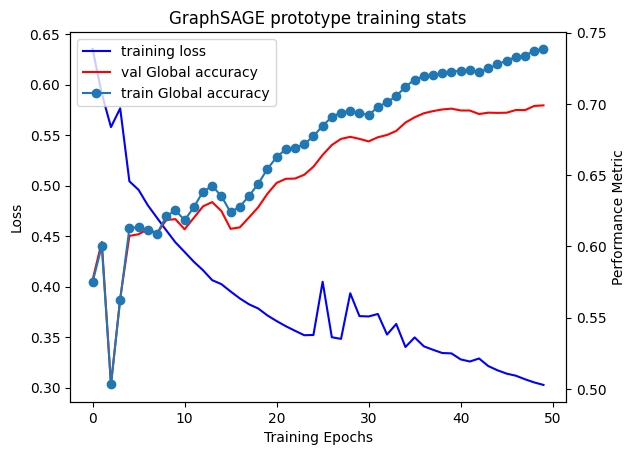

In [ ]:
losses = []
train_scores = []
val_scores = []
metric = accuracy_score
metric_name = "Global accuracy"

for epoch in range(args["epochs"]):
    if epoch%10 == 0:
        printb = True
    else:
        printb = False

    loss = train(model,optimizer,train_data,printb)
    train_score = test(model,train_data,metric)
    val_score = test(model,val_data,metric)
    losses.append(loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

plot_training_stats("GraphSAGE prototype training stats",losses,train_scores,val_scores,metric_name)

In [ ]:
full_test(model,test_data,200,False)

{('gene_protein', 'ppi', 'gene_protein'): [0.65, 0.59, 0.65, 195.0],
 ('gene_protein', 'gda', 'disease'): [0.7, 0.63, 0.7, 166.0],
 ('gene_protein', 'pathway_protein', 'pathway'): [0.72, 0.65, 0.72, 176.0],
 ('disease', 'disease_disease', 'disease'): [0.61, 0.56, 0.61, 200.0],
 ('gene_protein', 'form_complex', 'complex'): [0.64, 0.59, 0.64, 200.0],
 ('disease', 'disease_disease', 'bert_group'): [0.54, 0.52, 0.54, 104.0],
 ('bert_group', 'disease_disease', 'bert_group'): [0.52, 0.51, 0.52, 107.0]}

# Explore hyperparameters

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def perform_hyperparameter_search(param_grid, train_set, val_set, save_weights=False, early_stop=False):
  default = {
      'hidden_size': [32],
      'weight_decay': [1e-5],
      'lr': [0.01],
      'max_epochs':[10],
      "aggr":["mean"],
      "num_features":[10],
      "feature_type":["random"],
      "pred_mode":["gda_only"]
  }

  for arg in default:
    if arg not in param_grid:
      param_grid[arg] = default[arg]

  grid = ParameterGrid(param_grid)
  auc_results = {}
  auc_results_2 = []
  best_model = None
  best_model_eid = 0

  eid = 0 # experiment id
  for params in grid:
    # Index of the model, represents the parameters
    index = '; '.join(x + '_' + str(y) for x, y in params.items())
    print(index)

    # Launch a training experiment using the current set of parameters
    val_auc,current_model = launch_experiment(eid,
                   params,
                   train_set,
                   val_set,
                   save_weights=save_weights,
                   early_stop=early_stop)
    
    auc_results[index] = val_auc
    params["auc"] = val_auc
    auc_results_2.append(params)

    if max(auc_results, key = auc_results.get) == index:
      best_model = current_model
      best_model_eid = eid
    eid += 1

    print(f"Validation AUC: {round(val_auc,2)}. Iteration: {eid} of {grid.__len__()}")

  # Select the best results
  best_auc_model_params = grid[best_model_eid]

  return best_auc_model_params, best_model, auc_results_2

def launch_experiment(eid, params, train_set, val_set, save_weights=False, early_stop=False):
  
  # Construct the features to be used.
  train_set = initialize_features(train_set,params["feature_type"],params["num_features"])
  val_set = initialize_features(val_set,params["feature_type"],params["num_features"])
  train_set.to(device)
  val_set.to(device)

  #Initialize model
  model = HeteroGNN(train_set,params["pred_mode"],params["hidden_size"],params["aggr"])

  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params["weight_decay"])

  prev_train_loss = 0.1 # Set to a small non-zero value
  for epoch in range(params['max_epochs']):
    train_loss = train(model,optimizer,train_set,False)
    #Puedo calcular el val_auc en cada época si lo voy a graficar o usar para early stop, sino no vale la pena 
    #Lo calculo cuando termino

    #val_auc = test(model,val_set,roc_auc_score)

    # we can also add logic here to save the weights of the model if this current epoch 
    # gives the best performance so far. Mostly passing in eid to construct a filename
    # for saving the model weights.

    if early_stop:
      loss_delta = abs(train_loss - prev_train_loss)
      # Stop criteria:
      # loss changing <10% from previous epoch
      # we can also add a criteria like
      # validation ap less than train ap by more than 0.3.
      # the second criteria suggests the gap is large between train/valid results
      # meaning we could be overfitting if we continue.
      if loss_delta / prev_train_loss < 0.1:
        break

  val_auc = test(model,val_set,roc_auc_score)

  return val_auc, model

In [ ]:
# Parameters for GPU training
parameters = {
      'hidden_size': [32,64],
      'weight_decay': [1e-5,1e-3,0],
      'lr': [0.01,0.001,0.1],
      'max_epochs':[400],
      "aggr":["mean","sum","max"],
      "num_features":[10,50,100,200],
      "feature_type":["random","ones"],
      "pred_mode":["gda_only"]
  }

best_auc_model_params, best_model, all_results = perform_hyperparameter_search(parameters, train_data, val_data)
print("Best AUC Model:", best_auc_model_params)

aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_10; pred_mode_gda_only; weight_decay_1e-05
Validation AUC: 0.78. Iteration: 1 of 432
aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_10; pred_mode_gda_only; weight_decay_0.001
Validation AUC: 0.82. Iteration: 2 of 432
aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_10; pred_mode_gda_only; weight_decay_0
Validation AUC: 0.78. Iteration: 3 of 432
aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_50; pred_mode_gda_only; weight_decay_1e-05
Validation AUC: 0.72. Iteration: 4 of 432
aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_50; pred_mode_gda_only; weight_decay_0.001
Validation AUC: 0.72. Iteration: 5 of 432
aggr_mean; feature_type_random; hidden_size_32; lr_0.01; max_epochs_400; num_features_50; pred_mode_gda_only; weight_decay_0
Validation AUC: 0.72. It

In [ ]:
best_model

HeteroGNN(
  (bns1): ModuleDict(
    (gene_protein): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (disease): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pathway): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (complex): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bert_group): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relus1): ModuleDict(
    (gene_protein): LeakyReLU(negative_slope=0.01)
    (disease): LeakyReLU(negative_slope=0.01)
    (pathway): LeakyReLU(negative_slope=0.01)
    (complex): LeakyReLU(negative_slope=0.01)
    (bert_group): LeakyReLU(negative_slope=0.01)
  )
  (loss_fn): BCEWithLogitsLoss()
  (convs1): HeteroGNNWrapperConv(
    (modules): ModuleList(
      (0): HeteroGNNConv()
      (1): HeteroGNNConv()
      (2): HeteroGNNConv()
      (3): HeteroGNNConv()
      (4): H

# Make predictions

In [ ]:
data = initialize_features(data,best_auc_model_params["feature_type"],best_auc_model_params["num_features"])
transform = T.Compose([T.ToSparseTensor(remove_edge_index=False),T.ToDevice(device)])
data = transform(data)

In [ ]:
@torch.no_grad()
def prioritize(model,node_index,node_type,gene_encodings,disease_encodings,node_map=node_map,node_data=node_data):
    model.eval()

    if node_type == "disease":
        disease_index = node_map["disease"][node_index]
        disease_vector = disease_encodings[disease_index]
        predicted_edges = model.decode_pred(gene_encodings,disease_vector)
        ranked_edges, ranked_indices = torch.sort(predicted_edges, descending=True)
        results = pd.DataFrame({"score":ranked_edges.cpu().numpy(),"heterodata_index":ranked_indices.cpu().numpy()})
        results.score = results.score.round(3)
        prediction_dataframe = pd.DataFrame({"original_index":node_map["gene_protein"].keys(),"heterodata_index":node_map["gene_protein"].values()})

    elif node_type == "gene_protein":
        gene_index = node_map["gene_protein"][node_index]
        gene_vector = gene_encodings[gene_index]
        predicted_edges = model.decode_pred(disease_encodings,gene_vector)
        ranked_edges, ranked_indices = torch.sort(predicted_edges, descending=True)
        results = pd.DataFrame({"score":ranked_edges.cpu().numpy(),"heterodata_index":ranked_indices.cpu().numpy()})
        results.score = results.score.round(3)
        prediction_dataframe = pd.DataFrame({"original_index":node_map["disease"].keys(),"heterodata_index":node_map["disease"].values()})


    prediction_dataframe = pd.merge(prediction_dataframe,node_data["node_name"],left_on="original_index",right_index=True)
    ranked_predictions = pd.merge(prediction_dataframe,results,left_on="heterodata_index",right_on="heterodata_index").sort_values(by="score",ascending=False).reset_index(drop=True)
    ranked_predictions.index.name = "rank"

    return ranked_predictions
        

In [ ]:
with torch.no_grad():
    model.eval()
    encodings = best_model.encode(data)
    gene_encodings = encodings["gene_protein"]
    disease_encodings = encodings["disease"]

Tengo los encodings para los dos tipos de nodos que me interesan. Si quisiera TODOS los posibles enlaces, directamente hago matmul las dos matrices de embedding.
El resultado es una matriz de dimensión n_genes x n_enfermedades. Es algo como una matriz de adyacencia probabilística, cada valor i,j representa la probabilidad de que haya un enlace entre el par de nodos (i,j)
Ahora falta mapear los resultados a los nodos y rankearlos como queremos. Podemos mirarlo como un ranking general o pedir el ranking para un gen/enfermedad en particular.

Pero es una matriz enorme, con millones de elementos. Para obtener el ranking tendría que sortear esto y es muy costoso computacionalmente. Entonces en vez de eso elijo que enfermedades quiero ver (o genes) y hago matmul pero con esa matriz reducida

In [ ]:
node_type = "disease"
demo = node_data[node_data.node_type == node_type].sample(1)
node_index = demo.index.values[0]
node_name = demo.loc[node_index,"node_name"]

results = prioritize(model,node_index,node_type,gene_encodings,disease_encodings)
print(f"Ranked edges for {node_type}: {node_name}")
results

Ranked edges for disease: Cerebral Thrombosis


,original_index,heterodata_index,node_name,score
rank,,,,
0,14080,15606,TBCA,1.0
1,15334,9572,RIN3,1.0
2,18096,6102,CD59,1.0
3,14361,15543,TRHR,1.0
4,7913,8440,IMPDH1,1.0
...,...,...,...,...
17317,15050,6272,THTPA,0.0
17318,9101,15012,KRTAP5-7,0.0
17319,9102,15013,KRTAP5-11,0.0


In [ ]:
y_type = "disease" if node_type == "gene_protein" else "gene_protein"
existing_edges = edge_data.loc[(edge_data.x_index == node_index) & (edge_data.y_type == y_type),"y_index"].values
results.reset_index().set_index("original_index").loc[existing_edges]

,rank,heterodata_index,node_name,score
original_index,,,,
9324,3329,6635,SERPINC1,0.980
14657,1370,7214,VWF,0.994
10517,558,10782,PLAT,0.998


In [ ]:
test_data_2 = initialize_features(test_data,best_auc_model_params["feature_type"],best_auc_model_params["num_features"]).to(device)
full_test(best_model,test_data_2,200,False)

{('gene_protein', 'gda', 'disease'): [0.82, 0.74, 0.82, 156.0]}

# Save best model weights and parameters

In [ ]:
best_auc_model_params

{'weight_decay': 0.001,
 'pred_mode': 'gda_only',
 'num_features': 10,
 'max_epochs': 400,
 'lr': 0.01,
 'hidden_size': 64,
 'feature_type': 'random',
 'aggr': 'sum'}

In [ ]:
def save_model(model,param_dict,folder_path,model_name):
    date = datetime.datetime.now()
    fdate = date.strftime("%d_%m_%y__%I_%M")
    fname = f"{model_name}_{fdate}"

    torch.save(model.state_dict(), f"{folder_path}{fname}.pth")

    with open(f"{folder_path}params_{fname}.pickle", 'wb') as handle:
        pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
save_model(best_model,best_auc_model_params,models_folder,"graphsage_prototype_best")

In [ ]:
def load_model_data(file_name,file_folder):
    params_path = f"{file_folder}params_{file_name}.pickle"
    state_dict_path = f"{file_folder}{file_name}.pth"

    state_dict = torch.load(state_dict_path)

    with open(params_path, 'rb') as handle:
        params = pickle.load(handle)
    
    return state_dict, params

def load_HeteroGNN(state_dict,params,data):
    data = initialize_features(data,params["feature_type"],params["num_features"])
    model = HeteroGNN(data,params["pred_mode"],params["hidden_size"],params["aggr"])
    model.load_state_dict(state_dict)

    return model, data

In [ ]:
model_name = "graphsage_prototype_best_31_03_23__01_19"
state_dict, params = load_model_data(model_name,models_folder)
saved_model, new_data = load_HeteroGNN(state_dict,params,data)

FileNotFoundError: ignored

In [ ]:
with torch.no_grad():
    saved_model.eval()
    new_encodings = saved_model.encode(new_data)

In [ ]:
new_encodings

{'gene_protein': tensor([[ 0.0239,  0.0208, -0.2280,  ...,  0.4040, -0.0263, -0.0583],
         [-0.1726, -0.1393, -0.3212,  ...,  0.1179,  0.1834, -0.0242],
         [ 0.0547,  0.0228, -0.2313,  ...,  0.4395, -0.0222, -0.0631],
         ...,
         [-0.2098, -0.1425, -0.3507,  ...,  0.0945,  0.2245, -0.0459],
         [ 0.0118,  0.0559, -0.2165,  ...,  0.4412, -0.0156, -0.0815],
         [ 0.0011,  0.0313, -0.2675,  ...,  0.3687, -0.0307, -0.0664]]),
 'disease': tensor([[ 0.0730, -0.0022, -0.0235,  ...,  0.1237,  0.0491, -0.0309],
         [-0.0434, -0.0764, -0.0974,  ...,  0.1828,  0.1271,  0.0007],
         [-0.0509,  0.0547, -0.1454,  ...,  0.2979,  0.1364, -0.1076],
         ...,
         [ 0.1884,  0.1128,  0.1976,  ..., -0.0930,  0.1157,  0.0733],
         [ 0.1934,  0.1529,  0.2694,  ..., -0.1473,  0.1051,  0.0885],
         [ 0.1844,  0.1006,  0.2357,  ..., -0.1327,  0.0924,  0.0670]]),
 'pathway': tensor([[-0.1262, -0.0067,  0.1201,  ...,  0.3113, -0.0086, -0.0949],
       

In [ ]:
experiment_results = pd.DataFrame(all_results)
experiment_results.to_csv(experiments_folder+"graphsage_prototype.csv")

In [ ]:
experiment_results.sort_values(by="auc",ascending=False)

,aggr,feature_type,hidden_size,lr,max_epochs,num_features,pred_mode,weight_decay,auc
181,sum,random,64,0.010,400,10,gda_only,0.00100,0.836177
145,sum,random,32,0.010,400,10,gda_only,0.00100,0.835403
325,max,random,64,0.010,400,10,gda_only,0.00100,0.824948
337,max,random,64,0.001,400,10,gda_only,0.00100,0.821556
289,max,random,32,0.010,400,10,gda_only,0.00100,0.821477
...,...,...,...,...,...,...,...,...,...
138,mean,ones,64,0.100,400,100,gda_only,0.00001,0.593894
279,sum,ones,64,0.100,400,50,gda_only,0.00001,0.573262
10,mean,random,32,0.010,400,200,gda_only,0.00100,0.568918
190,sum,random,64,0.010,400,200,gda_only,0.00100,0.515097
